In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import matplotlib.cm as cm


# CSV file

In [3]:
data = pd.read_csv('Datasets/minute_weather.csv')

1. rowID: unique number for each row (Unit: NA)
2. hpwren_timestamp: timestamp of measure (Unit: year-month-day hour:minute:second)
3. air_pressure: air pressure measured at the timestamp (Unit: hectopascals)
4. air_temp: air temperature measure at the timestamp (Unit: degrees Fahrenheit)
5. avg_wind_direction: wind direction averaged over the minute before the timestamp (Unit: degrees, with 0 means coming from the North, and increasing clockwise)
6. avg_wind_speed: wind speed averaged over the minute before the timestamp (Unit: meters per second)
7. max_wind_direction: highest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and increasing clockwise)
8. max_wind_speed: highest wind speed in the minute before the timestamp (Unit: meters per second)
9. min_wind_direction: smallest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and inceasing clockwise)
10. min_wind_speed: smallest wind speed in the minute before the timestamp (Unit: meters per second)
11. rain_accumulation: amount of accumulated rain measured at the timestamp (Unit: millimeters)
12. rain_duration: length of time rain has fallen as measured at the timestamp (Unit: seconds)
13. relative_humidity: relative humidity measured at the timestamp (Unit: percent)

In [4]:
data.shape

(1587257, 13)

In [5]:
data.head()


,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


# data sampling 

In [6]:
sampled_df = data[(data['rowID'] % 10) == 0]                   # every 10th row
sampled_df.shape

(158726, 13)

# Statistics

In [7]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [8]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [9]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)


# Drop all the Rows with Empty rain_duration and rain_accumulation

In [10]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

In [11]:
rows_before - rows_after  # row dropped

46

In [12]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

# select clustering


In [13]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed','relative_humidity']
select_df = sampled_df[features]

In [14]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [15]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
...,...,...,...,...,...,...,...
1587210,915.9,75.56,330.0,1.0,341.0,1.3,47.8
1587220,915.9,75.56,330.0,1.1,341.0,1.4,48.0
1587230,915.9,75.56,344.0,1.4,352.0,1.7,48.0
1587240,915.9,75.20,359.0,1.3,9.0,1.6,46.3


# scaling the feature using standardScalar

In [16]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

# k mean clustering

In [17]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
# print("model\n", model)

# centers we formed
centers = model.cluster_centers_
centers

array([[-0.15853097,  0.86132105, -1.31090932, -0.58995578, -1.16647766,
        -0.60524424, -0.64378131],
       [ 0.2622354 , -0.99296415,  0.66297927, -0.5470297 ,  0.85425072,
        -0.52928754,  1.15512597],
       [-0.68395712,  0.5563577 ,  0.17794134, -0.5874288 ,  0.34820561,
        -0.60063416, -0.12405406],
       [-1.17566979, -0.87925574,  0.4459235 ,  1.97042386,  0.53804442,
         1.93164288,  0.91829396],
       [-0.84445183, -1.1961694 ,  0.37490116,  0.33864883,  0.47325951,
         0.32668886,  1.3624128 ],
       [ 0.23387569,  0.32030614,  1.88788295, -0.65189107, -1.55170411,
        -0.57673181, -0.28381621],
       [ 0.74445771,  0.42017441,  0.28820925, -0.5286705 ,  0.47544195,
        -0.53506113, -0.77450524],
       [ 1.37156393, -0.08461038, -1.20706281, -0.04114946, -1.07621148,
        -0.02035019, -0.97835753],
       [ 0.05925642, -0.78600318, -1.19642739, -0.57041924, -1.04248642,
        -0.58490217,  0.876879  ],
       [ 1.18888797, -0.2550

# Plots

In [18]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [19]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [20]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-0.158531,0.861321,-1.310909,-0.589956,-1.166478,-0.605244,-0.643781,0
1,0.262235,-0.992964,0.662979,-0.547030,0.854251,-0.529288,1.155126,1
2,-0.683957,0.556358,0.177941,-0.587429,0.348206,-0.600634,-0.124054,2
3,-1.175670,-0.879256,0.445924,1.970424,0.538044,1.931643,0.918294,3
4,-0.844452,-1.196169,0.374901,0.338649,0.473260,0.326689,1.362413,4
5,0.233876,0.320306,1.887883,-0.651891,-1.551704,-0.576732,-0.283816,5
6,0.744458,0.420174,0.288209,-0.528670,0.475442,-0.535061,-0.774505,6
7,1.371564,-0.084610,-1.207063,-0.041149,-1.076211,-0.020350,-0.978358,7
8,0.059256,-0.786003,-1.196427,-0.570419,-1.042486,-0.584902,0.876879,8
9,1.188888,-0.255078,-1.154960,2.130100,-1.053466,2.247414,-1.134537,9


# Dry days

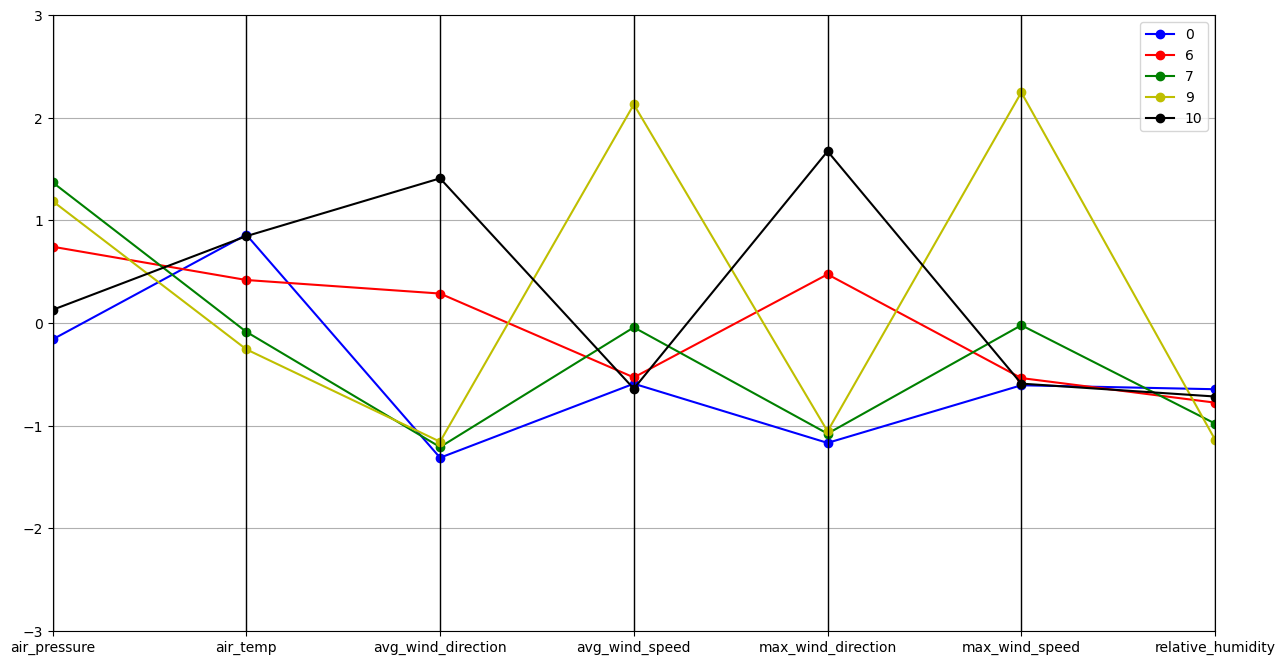

In [21]:
parallel_plot(P[P['relative_humidity'] < -0.5])

# warm days

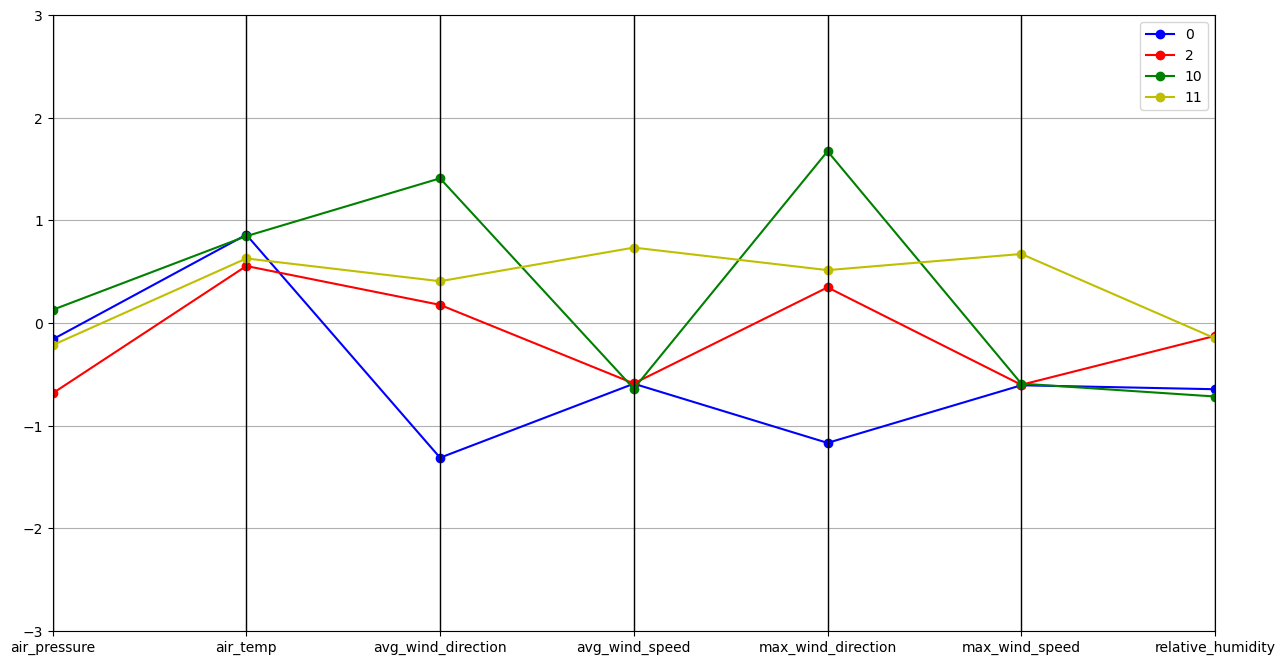

In [22]:
parallel_plot(P[P['air_temp'] > 0.5])

# Cool days

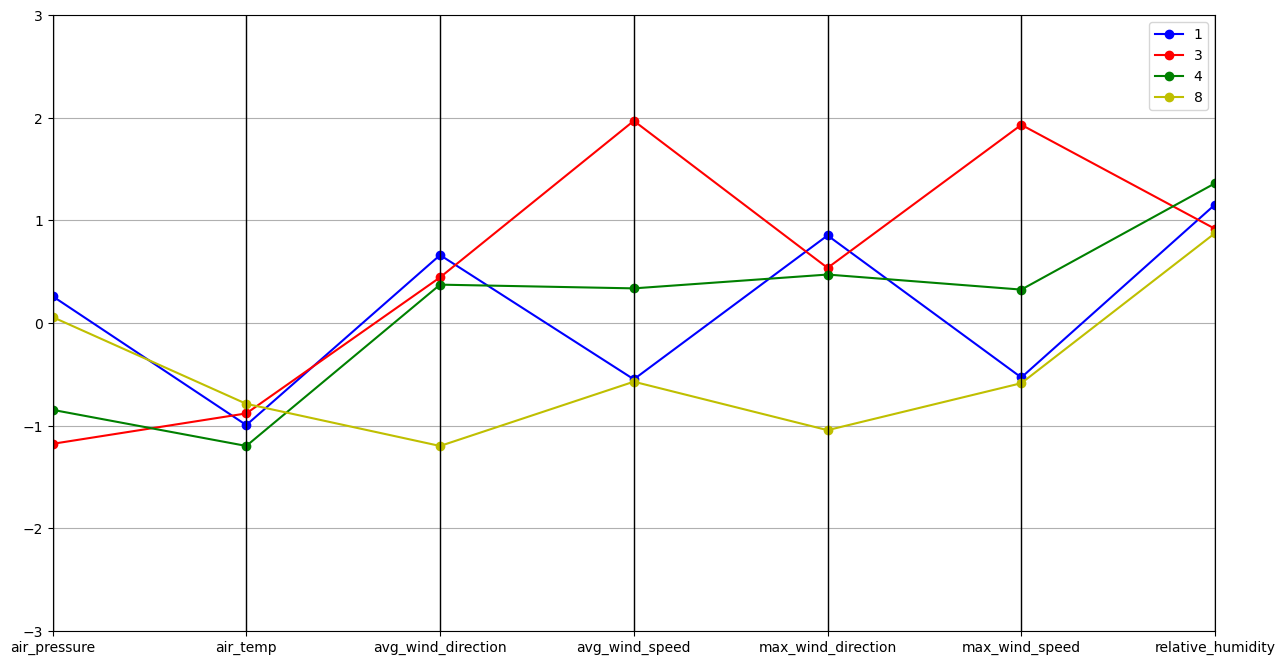

In [23]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])

In [24]:
km = KMeans(n_clusters=12)
model1 = km.fit(X)
# print("model\n", model)

# centers we formed
c = model1.cluster_centers_
c

array([[ 0.13591013,  0.83310747,  1.41358139, -0.63921527,  1.67810674,
        -0.59022597, -0.71379727],
       [-0.16256483,  0.86262287, -1.31189605, -0.58930867, -1.16799054,
        -0.60465856, -0.64166475],
       [-1.183028  , -0.87009575,  0.44683282,  1.98342663,  0.53831237,
         1.94448476,  0.90847836],
       [-0.20805764,  0.63341383,  0.40881423,  0.73475633,  0.51703856,
         0.67276031, -0.15371346],
       [ 0.2525582 , -0.99695131,  0.65812228, -0.54619671,  0.84838095,
        -0.52890796,  1.15786072],
       [ 0.23422959,  0.32038874,  1.88815273, -0.65179307, -1.55172536,
        -0.57665647, -0.28363417],
       [-0.72686964,  0.50910228,  0.17152892, -0.58162238,  0.34090025,
        -0.5950477 , -0.08597749],
       [ 1.36968635, -0.08254879, -1.20476547, -0.05188451, -1.0732297 ,
        -0.03159575, -0.97775402],
       [ 1.1898306 , -0.25439343, -1.15493364,  2.12202523, -1.05340462,
         2.23878781, -1.13465823],
       [-0.83605819, -1.2047

In [27]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=6)  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(X_scaled)

# Calculate Davies-Bouldin Index
# Note: DBSCAN may produce noise points labeled as -1; filter them out for DBI calculation
if len(set(labels)) > 1:  # Ensure there are at least two clusters
    db_index = davies_bouldin_score(X_scaled[labels != -1], labels[labels != -1])
    print(f'Davies-Bouldin Index (DBSCAN): {db_index:.2f}')
else:
    print("DBSCAN did not find enough clusters.")

Davies-Bouldin Index (DBSCAN): 0.02


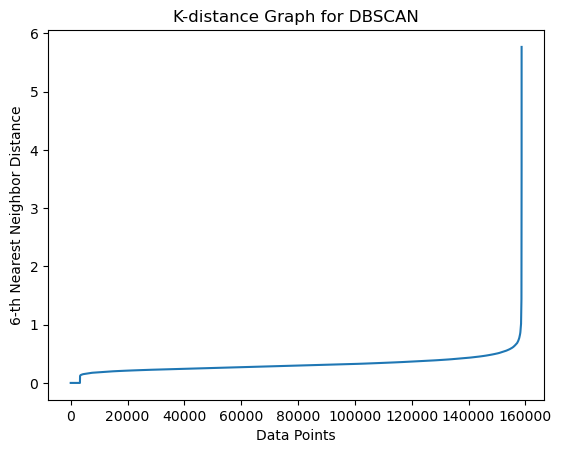

In [34]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Find the distances to k-th nearest neighbors
k = 6  # The min_samples you used in DBSCAN
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort and plot the k-distances
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title('K-distance Graph for DBSCAN')
plt.show()


In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Example data (replace with your actual data)
# X is your original feature data (e.g., weather data)
X = np.random.rand(15868, 10)  # Example with 15,868 samples and 10 features (replace with actual data)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=6)  # Adjust eps and min_samples as needed
labels = dbscan.fit_predict(X_scaled)

# Check shapes of data and labels to ensure consistency
print(f"Shape of X_scaled: {X_scaled.shape}")  # Should be (15868, 10)
print(f"Length of DBSCAN labels: {len(labels)}")  # Should be 15868 (same as X_scaled)

# Ensure there are valid clusters (exclude noise points labeled as -1)
valid_labels = labels != -1  # Exclude noise points

# Check if we have any valid clusters
if np.any(valid_labels):
    # Davies-Bouldin Index (excluding noise points)
    db_index = davies_bouldin_score(X_scaled[valid_labels], labels[valid_labels])
    print(f'Davies-Bouldin Index (DBSCAN): {db_index:.2f}')
    
    # Silhouette Score (excluding noise points)
    sil_score = silhouette_score(X_scaled[valid_labels], labels[valid_labels])
    print(f"Silhouette Score: {sil_score:.2f}")
else:
    print("DBSCAN did not find any valid clusters or only found noise points.")


Shape of X_scaled: (15868, 10)
Length of DBSCAN labels: 15868
DBSCAN did not find any valid clusters or only found noise points.


Applying DBSCAN...
Number of clusters found by DBSCAN (excluding noise): 0
DBSCAN did not find valid clusters.


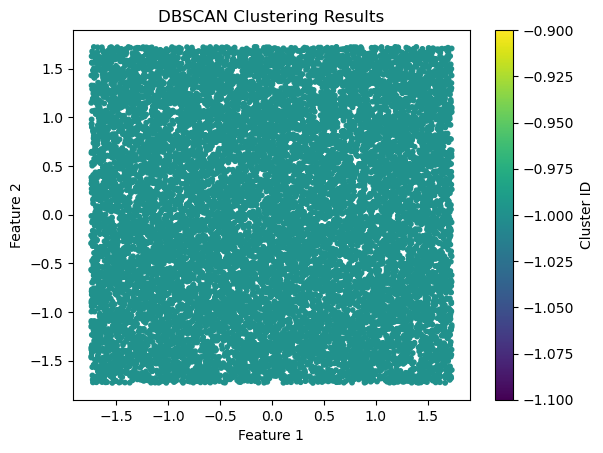

Applying KMeans...
KMeans - Davies-Bouldin Index: 2.12
KMeans - Silhouette Score: 0.07


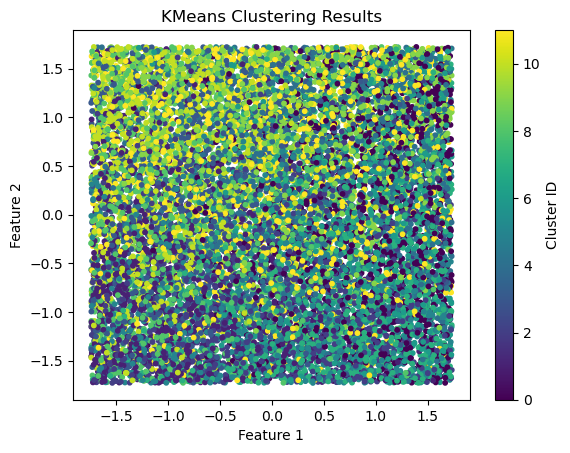

Applying GMM...
GMM - Davies-Bouldin Index: 2.65
GMM - Silhouette Score: 0.04


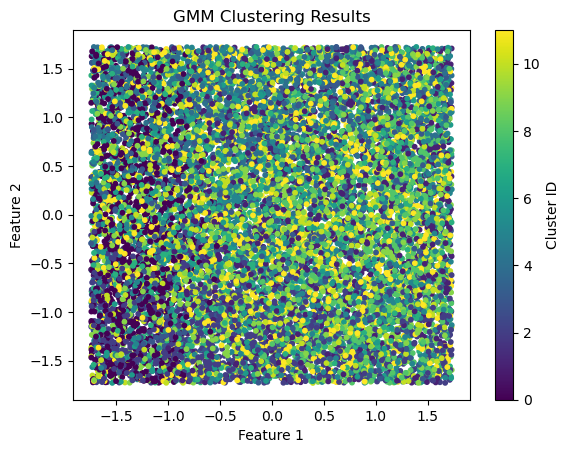

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Load your data (Replace this with actual data if needed)
X = np.random.rand(15868, 10)  # Example data

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 1. DBSCAN Clustering ---
print("Applying DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples
dbscan_labels = dbscan.fit_predict(X_scaled)

# Check the number of clusters
unique_labels = np.unique(dbscan_labels)
n_clusters_dbscan = len(unique_labels) - (1 if -1 in unique_labels else 0)
print(f"Number of clusters found by DBSCAN (excluding noise): {n_clusters_dbscan}")

# --- DBSCAN Metric Calculation ---
if n_clusters_dbscan > 1:  # Ensure valid clusters exist
    valid_mask = dbscan_labels != -1  # Exclude noise
    db_index_dbscan = davies_bouldin_score(X_scaled[valid_mask], dbscan_labels[valid_mask])
    sil_score_dbscan = silhouette_score(X_scaled[valid_mask], dbscan_labels[valid_mask])
    print(f"DBSCAN - Davies-Bouldin Index: {db_index_dbscan:.2f}")
    print(f"DBSCAN - Silhouette Score: {sil_score_dbscan:.2f}")
else:
    print("DBSCAN did not find valid clusters.")

# --- DBSCAN Visualization ---
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title("DBSCAN Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster ID')
plt.show()

# --- 2. KMeans Clustering ---
print("Applying KMeans...")
kmeans = KMeans(n_clusters=12, n_init=10)  # Adjust n_clusters
kmeans_labels = kmeans.fit_predict(X_scaled)

# --- KMeans Metric Calculation ---
db_index_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)
sil_score_kmeans = silhouette_score(X_scaled, kmeans_labels)
print(f"KMeans - Davies-Bouldin Index: {db_index_kmeans:.2f}")
print(f"KMeans - Silhouette Score: {sil_score_kmeans:.2f}")

# --- KMeans Visualization ---
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=10)
plt.title("KMeans Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster ID')
plt.show()

# --- 3. Gaussian Mixture Models (GMM) ---
print("Applying GMM...")
gmm = GaussianMixture(n_components=12, random_state=42)  # Adjust n_components
gmm_labels = gmm.fit_predict(X_scaled)

# --- GMM Metric Calculation ---
db_index_gmm = davies_bouldin_score(X_scaled, gmm_labels)
sil_score_gmm = silhouette_score(X_scaled, gmm_labels)
print(f"GMM - Davies-Bouldin Index: {db_index_gmm:.2f}")
print(f"GMM - Silhouette Score: {sil_score_gmm:.2f}")

# --- GMM Visualization ---
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("GMM Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster ID')
plt.show()


Explained Variance Ratio by PCA: [0.10356733 0.10229785]


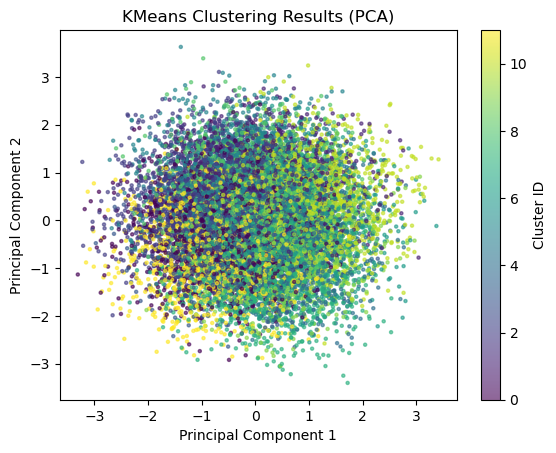

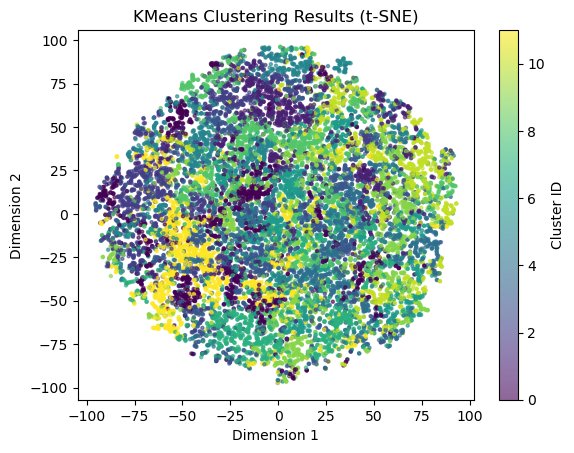

In [42]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Dimensionality Reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

# Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# KMeans with PCA visualization
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=5, alpha=0.6)
plt.title("KMeans Clustering Results (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster ID')
plt.show()

# KMeans with t-SNE visualization
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=5, alpha=0.6)
plt.title("KMeans Clustering Results (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Cluster ID')
plt.show()from sklearn.neighbors import NearestNeighbors

# Find the optimal eps value
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot the distances to determine a good eps
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.title("K-distance Graph for DBSCAN")
plt.xlabel("Data Points (sorted)")
plt.ylabel("k-distance")
plt.show()

